In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('../data/raw/training_v2.csv')

In [3]:
# drop columns with id (don't have an influence on the model)
df.drop('encounter_id', axis=1, inplace=True)
df.drop('patient_id', axis=1, inplace=True)
df.drop('hospital_id', axis=1, inplace=True)
df.drop('icu_id', axis=1, inplace=True)

In [4]:
col_list = []
with open("../data/raw/del_columns.txt", "r") as f:
    for line in f:
        col_list.append(line[:-1])
        
df.drop(columns=col_list, inplace=True, axis=1)

In [5]:
def preprocess_features(df):
    # 25 genders are nan => replace them with 'M'
    df['gender'] = df['gender'].fillna(df['gender'].value_counts().index[0])
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})
    
    df['ethnicity'] = df['ethnicity'].fillna("Other/Unknown")
    
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df["apache_2_bodysystem"].replace(und_diag, inplace = True)
    
    df["age"].fillna(int(df["age"].mean()), inplace=True)
    d = {range(1, 50): 1, range(50, 65): 2, range(65, 75): 3, range(75, 100): 4}
    df["age"] = df["age"].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    
    df.dropna(subset=['heart_rate_apache', 'temp_apache'], inplace=True)
    
    d1 = {range(25, 80): 1, range(80, 120): 2, range(120, 150): 3, range(150, 180): 4, range(180, 200): 5}
    df["heart_rate_apache"] = df["heart_rate_apache"].apply(lambda x: next((v for k, v in d1.items() if x in k), 0))

    df = pd.get_dummies(df, columns=["age", "heart_rate_apache"])
    
    d2 = {range(int(df["temp_apache"].min()), 37): 0, range(37, int(df["temp_apache"].max())+1): 1}
    df["temp_apache"] = df["temp_apache"].apply(lambda x: next((v for k, v in d2.items() if x in k), 0))
    
    df["urineoutput_apache"].fillna(df["urineoutput_apache"].mean(), inplace=True)
    
    # normalize urineoutput_apache
    x = df[['urineoutput_apache']].values.astype(float)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df["urineoutput_apache"] = x_scaled
    
    cat_columns = ["ethnicity",
                   "apache_3j_bodysystem", 
                   "apache_2_bodysystem"]

    df = pd.get_dummies(df, columns=cat_columns)

    df.fillna(df.mean(), inplace=True)

    return df

In [6]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.4f}".format(acc))
    print("Precision: {:.4f}".format(precision))
    print("Recall:    {:.4f}".format(recall))
    print("F1-score:  {:.4f}".format(f1))
    print("ROCAUC:    {:.4f}".format(roc_auc))
    print("AUPRC:     {:.4f}".format(auprc))

In [7]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
def plot_precision_recall_curve(y_test, probs):
    precision, recall, threshold = precision_recall_curve(y_test, probs)
    auc_score = auc(recall, precision)
    
    plt.title('2-class Precision-Recall curve')
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, 'r', marker='.')
    plt.show()

In [9]:
clean_df = preprocess_features(df)

In [10]:
y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [11]:
df = X_train.join(y_train)
pos_df = df[df.hospital_death == 1]
neg_df = df[df.hospital_death == 0].sample(n=pos_df.shape[0], random_state=1)

df_balanced = pd.concat([pos_df, neg_df])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [12]:
y_train = df_balanced.hospital_death
X_train = df_balanced.drop(columns="hospital_death")

In [13]:
len(X_train) + len(X_test)

38749

In [14]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
y_true = y_test.values

y_score = rf_clf.predict_proba(X_test)
y_pred = rf_clf.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.7924
Precision: 0.2626
Recall:    0.8138
F1-score:  0.3971
ROCAUC:    0.8830
AUPRC:     0.4621


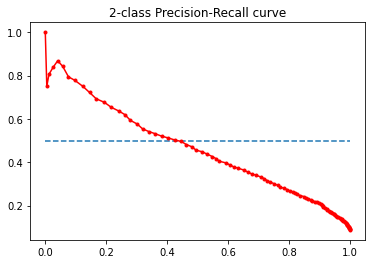

In [16]:
plot_precision_recall_curve(y_true, y_score[:, 1])

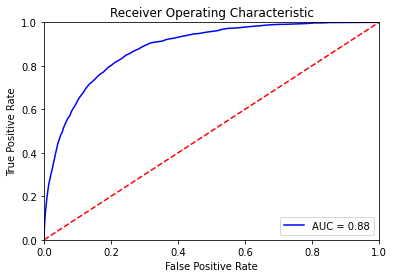

In [17]:
plot_roc_curve(y_true, y_score[:, 1])

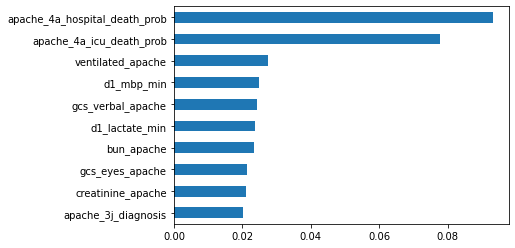

In [18]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()

In [19]:
#Create an object of the classifier.
from sklearn.ensemble import BaggingClassifier 

bbc = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        max_samples=0.4, # 0.4, 0.5
                        n_estimators=100,
                        random_state=0)

#Train the classifier.
bbc.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [20]:
# 0.4
y_score_bbc = bbc.predict_proba(X_test)
y_pred_bbc = bbc.predict(X_test)

evaluate(y_true, y_score_bbc[:, 1], y_pred_bbc)

Accuracy:  0.7885
Precision: 0.2586
Recall:    0.8129
F1-score:  0.3924
ROCAUC:    0.8777
AUPRC:     0.4288


In [21]:
feature_importances = np.mean([tree.feature_importances_ for tree in bbc.estimators_], axis=0)

In [22]:
feature_dict = dict(zip(X_train.columns, feature_importances))
feature_dict = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)[:10]}

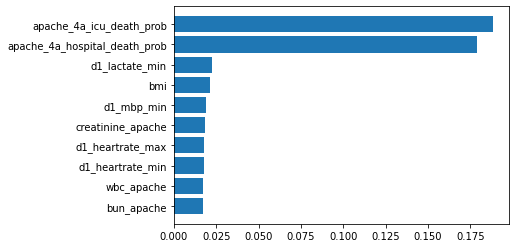

In [23]:
fig, ax = plt.subplots()
ax.barh(range(len(feature_dict)), list(feature_dict.values()), align='center')
y = range(len(feature_dict))
ax.set_yticks(y)
ax.set_yticklabels(list(feature_dict.keys()))
ax.invert_yaxis()

In [24]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
y_score_gb = gb_clf.predict_proba(X_test)
y_pred_gb = gb_clf.predict(X_test)

evaluate(y_true, y_score_gb[:, 1], y_pred_gb)

Accuracy:  0.8063
Precision: 0.2755
Recall:    0.8014
F1-score:  0.4100
ROCAUC:    0.8876
AUPRC:     0.5069


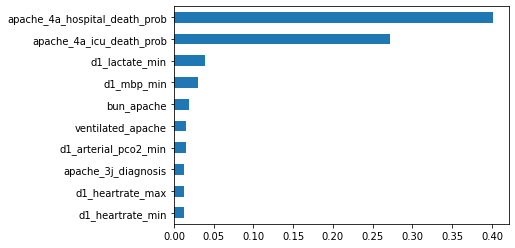

In [26]:
feat_importances = pd.Series(gb_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()